In [1]:
import pandas as pd
from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta
# 판다스 엑셀 익스포트를 위한 라이브러리
import openpyxl


PROJECT = "ballosodeuk"
bq = bigquery.Client(project=PROJECT)


query = """
select a.*, survival_prob, is_churn, current_shoji, frequency, recency, monetary, grade, loyalty_segment, days_since_last_activity
from
  (
    select * from `dm.agg_user_category_rank`
    where power_1_2 is not null
  ) a
left join
  (
    select user_id, survival_prob, is_churn, loyalty_segment, days_since_last_activity
    from `dm.agg_user_churn_daily`
    where cur_date = current_date() - 1
  ) b on a.user_id = b.user_id
left join 
  (
    select *
    from `dm.agg_user_rfm_daily`
    where register_dt = current_date() -1
  ) c on a.user_id = c.user_id
"""

df = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [94]:
# df.to_excel('seg_power.xlsx', engine='openpyxl', encoding='utf-8-sig', index=False)

In [2]:
df.is_churn.value_counts()

False    4686
True     1668
Name: is_churn, dtype: Int64

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6388 entries, 0 to 6387
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   6388 non-null   object 
 1   latest_order_dt           6388 non-null   dbdate 
 2   total_purchase_count      6388 non-null   Int64  
 3   ranking_1_1               6388 non-null   object 
 4   power_1_1                 6388 non-null   float64
 5   ranking_1_2               6388 non-null   object 
 6   power_1_2                 6388 non-null   float64
 7   ranking_1_3               1259 non-null   object 
 8   power_1_3                 1259 non-null   float64
 9   ranking_1_4               341 non-null    object 
 10  power_1_4                 341 non-null    float64
 11  ranking_1_5               105 non-null    object 
 12  power_1_5                 105 non-null    float64
 13  ranking_2_1               6388 non-null   object 
 14  power_2_

In [4]:
# 전처리 및 null 처리
import re
import datetime
today = datetime.datetime.now().date()

df.latest_order_dt = pd.to_datetime(df.latest_order_dt)

df['latest_order_dt'] = (today - df.latest_order_dt.dt.date).dt.days
df.info()


power_cols = [col for col in df.columns.tolist() if col.startswith('power')]
ranking_cols = [col for col in df.columns.tolist() if col.startswith('ranking')]
df[power_cols] = df[power_cols].fillna(0)
df[power_cols] = df[power_cols].astype(float)

df['power_1_2'] = df['power_1_2'].fillna(0)
df['power_1_2'] = df['power_1_2'].astype(float)

df['current_shoji'] = df['current_shoji'].fillna(0)
df['current_shoji'] = df['current_shoji'].astype(float)

df['frequency'] = df['frequency'].fillna(0)
df['frequency'] = df['frequency'].astype(float)

df['is_churn'] = df['is_churn'].fillna(True)

df['recency'] = df['recency'].fillna(0)
df['recency'] = df['recency'].astype(float)

df['monetary'] = df['monetary'].fillna(0)
df['monetary'] = df['monetary'].astype(float)

df['grade'] = df['grade'].fillna("DEAD")
df['grade'] = df['grade'].astype(str)

df['current_shoji'] = df['current_shoji'].fillna(0)
df['current_shoji'] = df['current_shoji'].astype(float)

df['survival_prob'] = df['survival_prob'].fillna(0)
df['survival_prob'] = df['survival_prob'].astype(float)

df['loyalty_segment'] = df['loyalty_segment'].fillna("DEAD")
df['loyalty_segment'] = df['loyalty_segment'].astype(str)

df['days_since_last_activity'] = df['days_since_last_activity'].fillna(9999)
df['days_since_last_activity'] = df['days_since_last_activity'].astype(float)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6388 entries, 0 to 6387
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   6388 non-null   object 
 1   latest_order_dt           6388 non-null   int64  
 2   total_purchase_count      6388 non-null   Int64  
 3   ranking_1_1               6388 non-null   object 
 4   power_1_1                 6388 non-null   float64
 5   ranking_1_2               6388 non-null   object 
 6   power_1_2                 6388 non-null   float64
 7   ranking_1_3               1259 non-null   object 
 8   power_1_3                 1259 non-null   float64
 9   ranking_1_4               341 non-null    object 
 10  power_1_4                 341 non-null    float64
 11  ranking_1_5               105 non-null    object 
 12  power_1_5                 105 non-null    float64
 13  ranking_2_1               6388 non-null   object 
 14  power_2_

In [73]:
# 스파스 인코딩 (기존 코드)
power_cols = [col for col in df.columns.tolist() if col.startswith('power')]
ranking_cols = [col for col in df.columns.tolist() if col.startswith('ranking')]
tst = df[ranking_cols+power_cols].copy()

pivot_dfs = []

# ranking_1_x와 power_1_x 처리
for i in range(1, 6):  
    # NaN 값을 피벗 전에 처리
    temp_df = tst[[f'ranking_1_{i}', f'power_1_{i}']].copy()
    temp_df[f'ranking_1_{i}'] = temp_df[f'ranking_1_{i}'].fillna('unknown')  # 또는 다른 값으로 대체
    
    pivot_df = temp_df.melt(
        id_vars=[f'ranking_1_{i}'], 
        value_vars=[f'power_1_{i}']
    ).reset_index()\
    .pivot(
        index='index', 
        columns=f'ranking_1_{i}', 
        values='value'
    ).fillna(0)
    
    # unknown 컬럼 제거 (필요한 경우)
    if 'unknown' in pivot_df.columns:
        pivot_df = pivot_df.drop('unknown', axis=1)
    
    pivot_df.columns = [f'{col}_1_{i}' for col in pivot_df.columns]
    pivot_dfs.append(pivot_df)

# ranking_2_x와 power_2_x 처리도 동일하게 수정
for i in range(1, 11):
    temp_df = tst[[f'ranking_2_{i}', f'power_2_{i}']].copy()
    temp_df[f'ranking_2_{i}'] = temp_df[f'ranking_2_{i}'].fillna('unknown')
    
    pivot_df = temp_df.melt(
        id_vars=[f'ranking_2_{i}'], 
        value_vars=[f'power_2_{i}']
    ).reset_index()\
    .pivot(
        index='index', 
        columns=f'ranking_2_{i}', 
        values='value'
    ).fillna(0)
    
    if 'unknown' in pivot_df.columns:
        pivot_df = pivot_df.drop('unknown', axis=1)
        
    pivot_df.columns = [f'{col}_2_{i}' for col in pivot_df.columns]
    pivot_dfs.append(pivot_df)

# 모든 피벗 테이블을 index를 기준으로 결합
final_df = pd.concat(pivot_dfs, axis=1)

# 동일한 카테고리를 하나로 합치는 코드
# 컬럼 이름에서 접미사(_1_1, _2_3 등)를 제거한 기본 카테고리명을 추출
def extract_category_name(col_name):
    # '_1_1', '_2_3' 등의 접미사를 제거하고 기본 카테고리명만 반환
    if '_1_' in col_name or '_2_' in col_name:
        # 마지막 '_' 이전까지의 문자열을 카테고리명으로 간주
        parts = col_name.split('_')
        if len(parts) >= 3:
            # 마지막 두 부분(숫자)을 제외한 나머지를 결합
            return '_'.join(parts[:-2])
    return col_name

# 동일한 카테고리를 그룹화
category_groups = {}
for col in final_df.columns:
    base_category = extract_category_name(col)
    if base_category not in category_groups:
        category_groups[base_category] = []
    category_groups[base_category].append(col)

# 동일한 카테고리의 컬럼들을 합쳐서 새로운 데이터프레임 생성
merged_df = pd.DataFrame(index=final_df.index)

for category, columns in category_groups.items():
    # 같은 카테고리의 컬럼들을 합산
    merged_df[category] = final_df[columns].sum(axis=1)

# merged_df가 최종 결과물이 됩니다
print(f"원래 컬럼 수: {final_df.shape[1]}")
print(f"병합 후 컬럼 수: {merged_df.shape[1]}")
print(f"병합된 카테고리 목록: {merged_df.columns.tolist()}")

원래 컬럼 수: 639
병합 후 컬럼 수: 102
병합된 카테고리 목록: ['가구-인테리어', '디지털-가전', '생활-건강', '스포츠-레저', '식품', '출산-육아', '패션의류', '패션잡화', '화장품-미용', '가구-인테리어(DIY자재-용품)', '가구-인테리어(거실가구)', '가구-인테리어(수납가구)', '가구-인테리어(수예)', '가구-인테리어(인테리어소품)', '가구-인테리어(침구단품)', '가구-인테리어(카페트-러그)', '가구-인테리어(홈데코)', '디지털-가전(PC액세서리)', '디지털-가전(계절가전)', '디지털-가전(노트북)', '디지털-가전(생활가전)', '디지털-가전(음향가전)', '디지털-가전(이미용가전)', '디지털-가전(주방가전)', '디지털-가전(주변기기)', '디지털-가전(휴대폰악세서리)', '생활-건강(건강관리용품)', '생활-건강(건강측정용품)', '생활-건강(공구)', '생활-건강(구강위생용품)', '생활-건강(문구-사무용품)', '생활-건강(발건강용품)', '생활-건강(생활용품)', '생활-건강(세탁용품)', '생활-건강(수납-정리용품)', '생활-건강(안마용품)', '생활-건강(애완)', '생활-건강(온열-찜질용품)', '생활-건강(욕실용품)', '생활-건강(의료용품)', '생활-건강(자동차용품)', '생활-건강(주방용품)', '생활-건강(청소용품)', '스포츠-레저(골프)', '스포츠-레저(기타스포츠용품)', '스포츠-레저(등산)', '스포츠-레저(스포츠액세서리)', '스포츠-레저(캠핑)', '스포츠-레저(헬스)', '식품(가공식품)', '식품(건강식품)', '식품(과자)', '식품(김치)', '식품(냉동-간편조리식품)', '식품(농산물)', '식품(다이어트식품)', '식품(반찬)', '식품(수산)', '식품(음료)', '식품(축산)', '출산-육아(물티슈)', '출산-육아(위생-건강용품)', '패션의류(남성언더웨어-잠옷)', '패션의류(남성의류)', '패션의류(여성언더웨어-잠옷)', '패션의류(여성의류)', '

<ipython-input-73-95ef1126ef6a>:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[category] = final_df[columns].sum(axis=1)
<ipython-input-73-95ef1126ef6a>:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[category] = final_df[columns].sum(axis=1)


In [74]:
merged_df.head()

,가구-인테리어,디지털-가전,생활-건강,스포츠-레저,식품,출산-육아,패션의류,패션잡화,화장품-미용,가구-인테리어(DIY자재-용품),가구-인테리어(거실가구),가구-인테리어(수납가구),가구-인테리어(수예),가구-인테리어(인테리어소품),가구-인테리어(침구단품),가구-인테리어(카페트-러그),가구-인테리어(홈데코),디지털-가전(PC액세서리),디지털-가전(계절가전),디지털-가전(노트북),디지털-가전(생활가전),디지털-가전(음향가전),디지털-가전(이미용가전),디지털-가전(주방가전),디지털-가전(주변기기),디지털-가전(휴대폰악세서리),생활-건강(건강관리용품),생활-건강(건강측정용품),생활-건강(공구),생활-건강(구강위생용품),생활-건강(문구-사무용품),생활-건강(발건강용품),생활-건강(생활용품),생활-건강(세탁용품),생활-건강(수납-정리용품),생활-건강(안마용품),생활-건강(애완),생활-건강(온열-찜질용품),생활-건강(욕실용품),생활-건강(의료용품),생활-건강(자동차용품),생활-건강(주방용품),생활-건강(청소용품),스포츠-레저(골프),스포츠-레저(기타스포츠용품),스포츠-레저(등산),스포츠-레저(스포츠액세서리),스포츠-레저(캠핑),스포츠-레저(헬스),식품(가공식품),식품(건강식품),식품(과자),식품(김치),식품(냉동-간편조리식품),식품(농산물),식품(다이어트식품),식품(반찬),식품(수산),식품(음료),식품(축산),출산-육아(물티슈),출산-육아(위생-건강용품),패션의류(남성언더웨어-잠옷),패션의류(남성의류),패션의류(여성언더웨어-잠옷),패션의류(여성의류),패션잡화(모자),패션잡화(양말),패션잡화(여성가방),패션잡화(여성신발),패션잡화(여행용가방-소품),패션잡화(장갑),패션잡화(패션소품),패션잡화(헤어액세서리),화장품-미용(남성화장품),화장품-미용(마스크-팩),화장품-미용(바디케어),화장품-미용(베이스메이크업),화장품-미용(뷰티소품),화장품-미용(색조메이크업),화장품-미용(선케어),화장품-미용(스킨케어),화장품-미용(클렌징),화장품-미용(향수),화장품-미용(헤어스타일링),화장품-미용(헤어케어),가구-인테리어(서재-사무용가구),가구-인테리어(솜류),가구-인테리어(주방가구),디지털-가전(영상가전),생활-건강(재활운동용품),스포츠-레저(배드민턴),스포츠-레저(수영),스포츠-레저(자전거),식품(아이스크림-빙수),출산-육아(안전용퓸),출산-육아(완구-매트),출산-육아(외출용품),패션잡화(남성신발),패션잡화(신발용품),패션잡화(주얼리),패션잡화(지갑)
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.500000,0.0,0.500000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.500000,0.5,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.333333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.666667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.400000,0.0,0.600000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.571429,0.0,0.285714,0.0,0.0,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.142857,0.0,0.142857,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
df_list = df[['depth1_list','depth1plus_list', 'depth3_list']]
df_num = df[['user_id','latest_order_dt', 'total_purchase_count','survival_prob', 'is_churn',
       'current_shoji', 'frequency', 'recency', 'monetary', 'grade',
       'loyalty_segment', 'days_since_last_activity']]



In [76]:
df_num_sp = df_num.merge(merged_df, left_index=True, right_index=True)
df_num_sp.grade.value_counts()

GOLD      2674
VIP       2014
SILVER     663
DEAD       555
IRON       482
Name: grade, dtype: int64

In [77]:
df_num_sp = df_num_sp.query("grade != 'DEAD'")
df_num_sp.head()

,user_id,latest_order_dt,total_purchase_count,survival_prob,is_churn,current_shoji,frequency,recency,monetary,grade,loyalty_segment,days_since_last_activity,가구-인테리어,디지털-가전,생활-건강,스포츠-레저,식품,출산-육아,패션의류,패션잡화,화장품-미용,가구-인테리어(DIY자재-용품),가구-인테리어(거실가구),가구-인테리어(수납가구),가구-인테리어(수예),가구-인테리어(인테리어소품),가구-인테리어(침구단품),가구-인테리어(카페트-러그),가구-인테리어(홈데코),디지털-가전(PC액세서리),디지털-가전(계절가전),디지털-가전(노트북),디지털-가전(생활가전),디지털-가전(음향가전),디지털-가전(이미용가전),디지털-가전(주방가전),디지털-가전(주변기기),디지털-가전(휴대폰악세서리),생활-건강(건강관리용품),생활-건강(건강측정용품),생활-건강(공구),생활-건강(구강위생용품),생활-건강(문구-사무용품),생활-건강(발건강용품),생활-건강(생활용품),생활-건강(세탁용품),생활-건강(수납-정리용품),생활-건강(안마용품),생활-건강(애완),생활-건강(온열-찜질용품),생활-건강(욕실용품),생활-건강(의료용품),생활-건강(자동차용품),생활-건강(주방용품),생활-건강(청소용품),스포츠-레저(골프),스포츠-레저(기타스포츠용품),스포츠-레저(등산),스포츠-레저(스포츠액세서리),스포츠-레저(캠핑),스포츠-레저(헬스),식품(가공식품),식품(건강식품),식품(과자),식품(김치),식품(냉동-간편조리식품),식품(농산물),식품(다이어트식품),식품(반찬),식품(수산),식품(음료),식품(축산),출산-육아(물티슈),출산-육아(위생-건강용품),패션의류(남성언더웨어-잠옷),패션의류(남성의류),패션의류(여성언더웨어-잠옷),패션의류(여성의류),패션잡화(모자),패션잡화(양말),패션잡화(여성가방),패션잡화(여성신발),패션잡화(여행용가방-소품),패션잡화(장갑),패션잡화(패션소품),패션잡화(헤어액세서리),화장품-미용(남성화장품),화장품-미용(마스크-팩),화장품-미용(바디케어),화장품-미용(베이스메이크업),화장품-미용(뷰티소품),화장품-미용(색조메이크업),화장품-미용(선케어),화장품-미용(스킨케어),화장품-미용(클렌징),화장품-미용(향수),화장품-미용(헤어스타일링),화장품-미용(헤어케어),가구-인테리어(서재-사무용가구),가구-인테리어(솜류),가구-인테리어(주방가구),디지털-가전(영상가전),생활-건강(재활운동용품),스포츠-레저(배드민턴),스포츠-레저(수영),스포츠-레저(자전거),식품(아이스크림-빙수),출산-육아(안전용퓸),출산-육아(완구-매트),출산-육아(외출용품),패션잡화(남성신발),패션잡화(신발용품),패션잡화(주얼리),패션잡화(지갑)
0,045696e7-11a9-4b00-9bee-abb3c1a6ff40,177,2,0.026767,False,421.0,1.0,176.0,21800.0,IRON,안정기 유저,26.0,0.500000,0.000000,0.500000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,804bf7e9-6613-4d60-95a8-4ff7a909f803,177,2,0.000000,True,481.0,1.0,176.0,52700.0,IRON,초기 유저,35.0,0.500000,0.500000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5d6e166d-9733-4e3a-af48-598e3052c461,177,3,0.000000,True,61.0,1.0,176.0,40600.0,IRON,장기 충성 유저,32.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.666667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6156672b-959c-4369-a72a-f8d9898ffee7,177,7,0.839796,False,438.0,2.0,176.0,82800.0,GOLD,최상위 충성 유저,2.0,0.000000,0.000000,0.571429,0.0,0.285714,0.0,0.0,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.142857,0.0,0.142857,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.142857,0.0,0.00000,0.142857,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,daacaf36-f529-4aeb-83cd-f48d41875881,38,23,0.825509,False,2441.0,15.0,37.0,604600.0,VIP,최상위 충성 유저,1.0,0.000

# 모델

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import NMF
from sklearn.cluster import AgglomerativeClustering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import skfuzzy as fuzz

pd.options.display.max_columns = None
# 모든 행과 열을 표시하도록 pandas 설정 변경
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [79]:
# 인코딩딩
le = LabelEncoder()
sc = StandardScaler()

grade_order = {
    'IRON': 0,    # 가장 낮은 등급
    'SILVER': 1,
    'GOLD': 2,
    'VIP': 3,     # 가장 높은 등급
}
segment_order = {
    "최상위 충성 유저" : 6,
    "장기 충성 유저" : 5,
    "충성 유저" : 4,
    "안정기 유저" : 3,
    "정착기 유저" : 2,
    "적응기 유저" : 1,
    "초기 유저" : 0,
}
# 순서대로 매핑
df_num_sp['grade_encoded'] = df_num_sp['grade'].map(grade_order)
df_num_sp['segment_encoded'] = df_num_sp['loyalty_segment'].map(segment_order)
df_num_sp['is_churn'] = df_num_sp.is_churn.map({True: 1, False: 0})

In [80]:
# 처리된 카테고리컬럼 드롭 & 유저아이디 인덱싱
df_num_sp.drop(['grade','loyalty_segment','latest_order_dt'],axis=1,inplace=True)
df_num_sp.set_index('user_id',inplace=True)

In [ ]:
#  'total_purchase_count' : 총 누적 구매 수 (int)
#  'survival_prob' : 현재 유저의 계산된 생존 확률 (float)
#  'is_churn' : 유저가 이탈했는지 여부. (1,0)
#  'current_shoji' : 현재 유저가 소유한 재산 (int)
#  'frequency' : 총 누적 구매 일 수(int)
#  'recency' : 오늘로부터 최근 구매 일의 기간 (int)
#  'monetary' : 누적 매출 (int)
#  'days_since_last_activity' : 오늘로부터 최근 활동 일의 기간 (int)
#  '가구-인테리어_1_1' : 유저가 구매한 상품의 카테고리 중, 계산된 선호도 (one hot encoded)
#  '디지털-가전_1_1' : 이하 내용 다 같음.
# ...

## 카테고리
NMF와 Fuzzy C-Means 조합은 매우 좋은 접근법입니다. 카테고리 개수가 45개와 594개로 많기 때문에 NMF를 통한 차원 축소는 효과적인 전략입니다. NMF(Non-negative Matrix Factorization)는 다음과 같은 장점이 있습니다:


음수가 없는 특성을 유지하므로 카테고리 선호도 데이터와 같은 양수 값에 적합합니다
원래 특성(카테고리)의 의미를 어느 정도 보존하면서 차원을 축소합니다
각 구성요소가 관련 카테고리들의 조합으로 해석될 수 있어 군집의 의미 파악에 도움이 됩니다

In [127]:
total_category = df_num_sp.iloc[:,8:-3].columns.tolist()
first_category = df_num_sp.iloc[:,8:17].columns.tolist()
second_category = df_num_sp.iloc[:,17:-3].columns.tolist()

print(len(first_category), len(second_category), len(total_category))


9 93 102


### total-category 기반 군집화

In [ ]:
# 모든 카테고리 데이터 사용 (second_category만 사용하던 것에서 total_category로 변경)
category_data = df_num_sp[total_category]  # second_category 대신 total_category 사용

# NMF로 차원 축소
n_components = 15
nmf = NMF(n_components=n_components, random_state=42)
reduced_data = nmf.fit_transform(category_data)

print('n-comp shape : ', reduced_data.shape)

# Fuzzy C-Means 대신 계층적 군집화(Agglomerative Clustering) 사용
from sklearn.cluster import AgglomerativeClustering

# 계층적 군집화 적용
n_clusters = 3
hierarchical = AgglomerativeClustering(
    n_clusters=n_clusters,
    linkage='ward'  # 'ward' 방식은 분산을 최소화하는 방향으로 군집화 (다른 옵션: 'average', 'complete')
)
cluster_labels = hierarchical.fit_predict(reduced_data)

# 군집 레이블 저장
df_num_sp['cluster'] = cluster_labels

n-comp shape :  (5833, 15)


<ipython-input-150-2550c1283224>:38: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distances, method='ward')


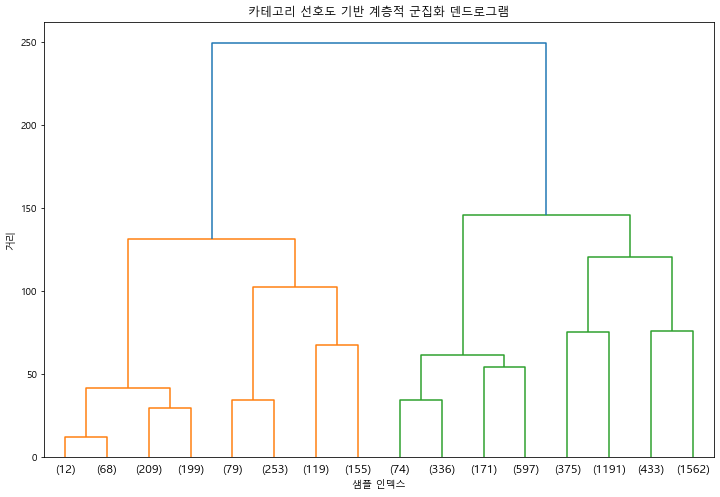


군집 0:
사용자 수: 4337 (74.4%)
주요 상위 카테고리:
  - 식품: 0.3674
  - 생활-건강: 0.2324
  - 화장품-미용: 0.1625
  - 디지털-가전: 0.0836
  - 패션잡화: 0.0828
주요 하위 카테고리:
  - 식품(음료): 0.1517
  - 생활-건강(주방용품): 0.1478
  - 식품(가공식품): 0.0884
  - 화장품-미용(스킨케어): 0.0644
  - 패션잡화(양말): 0.0622
  - 디지털-가전(주방가전): 0.0405
  - 식품(수산): 0.0315
  - 화장품-미용(바디케어): 0.0259
  - 식품(축산): 0.0244
  - 식품(냉동-간편조리식품): 0.0240
RFM 프로필:
  - recency: 44.39
  - frequency: 2.49
  - monetary: 48712.47

군집 1:
사용자 수: 968 (16.6%)
주요 상위 카테고리:
  - 식품: 0.5322
  - 생활-건강: 0.1656
  - 화장품-미용: 0.1572
  - 디지털-가전: 0.0500
  - 패션잡화: 0.0468
주요 하위 카테고리:
  - 식품(건강식품): 0.3932
  - 생활-건강(주방용품): 0.0888
  - 화장품-미용(스킨케어): 0.0777
  - 식품(음료): 0.0404
  - 패션잡화(양말): 0.0361
  - 식품(가공식품): 0.0333
  - 디지털-가전(주방가전): 0.0257
  - 화장품-미용(바디케어): 0.0229
  - 생활-건강(생활용품): 0.0172
  - 식품(농산물): 0.0168
RFM 프로필:
  - recency: 48.38
  - frequency: 3.20
  - monetary: 86460.73

군집 2:
사용자 수: 528 (9.1%)
주요 상위 카테고리:
  - 식품: 0.5403
  - 생활-건강: 0.1843
  - 화장품-미용: 0.1183
  - 패션잡화: 0.0676
  - 디지털-가전: 0.0569
주요 하위 카

In [150]:
# 덴드로그램 시각화를 위한 코드 (군집 구조 탐색에 유용)
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import pairwise_distances

def plot_dendrogram(model, **kwargs):
    # 링크 매트릭스 생성
    from scipy.cluster.hierarchy import linkage
    
    # 거리 행렬 계산
    distances = pairwise_distances(reduced_data)
    
    # 계층적 군집화 수행
    linkage_matrix = linkage(distances, method='ward')
    
    # 덴드로그램 플롯
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, **kwargs)
    plt.title('카테고리 선호도 기반 계층적 군집화 덴드로그램')
    plt.xlabel('샘플 인덱스')
    plt.ylabel('거리')
    plt.show()

# 덴드로그램 그리기 (샘플 수가 많은 경우 서브샘플링 필요)
if len(reduced_data) <= 100:  # 샘플이 적은 경우 전체 시각화
    plot_dendrogram(hierarchical, truncate_mode=None)
else:  # 샘플이 많은 경우 일부만 시각화
    plot_dendrogram(hierarchical, truncate_mode='level', p=3)

# 군집 분석
for cluster_id in range(n_clusters):
    cluster_mask = df_num_sp['cluster'] == cluster_id
    cluster_size = cluster_mask.sum()
    
    print(f"\n군집 {cluster_id}:")
    print(f"사용자 수: {cluster_size} ({cluster_size / len(df_num_sp) * 100:.1f}%)")
    
    # 각 군집의 카테고리 선호도 프로필
    # 상위 카테고리 선호도
    if len(first_category) > 0:
        top_first_categories = df_num_sp.loc[cluster_mask, first_category].mean().sort_values(ascending=False).head(5)
        
        print("주요 상위 카테고리:")
        for cat, score in zip(top_first_categories.index, top_first_categories.values):
            cat_name = cat.split('_')[0]  # 카테고리 이름만 추출
            print(f"  - {cat_name}: {score:.4f}")
    
    # 하위 카테고리 선호도
    top_second_categories = df_num_sp.loc[cluster_mask, second_category].mean().sort_values(ascending=False).head(10)
    
    print("주요 하위 카테고리:")
    for cat, score in zip(top_second_categories.index, top_second_categories.values):
        cat_name = cat.split('_')[0]  # 카테고리 이름만 추출
        print(f"  - {cat_name}: {score:.4f}")
    
    # RFM 프로필 (있는 경우)
    rfm_columns = ['recency', 'frequency', 'monetary']
    if all(col in df_num_sp.columns for col in rfm_columns):
        rfm_profile = df_num_sp.loc[cluster_mask, rfm_columns].mean()
        
        print("RFM 프로필:")
        for col, val in rfm_profile.items():
            print(f"  - {col}: {val:.2f}")

In [163]:
df_num_sp.groupby('cluster').agg({
    'survival_prob':'count',
})

,survival_prob
cluster,
0,4337
1,968
2,528


#### 군집 프로파일링

In [154]:
# 각 NMF 구성요소에 가장 큰 영향을 미치는 원본 카테고리 확인
all_category_columns = category_data.columns.tolist()
component_interpretations = {}

for i in range(n_components):
    component = nmf.components_[i]
    top_indices = component.argsort()[::-1][:10]  # 상위 10개 카테고리
    top_categories = [all_category_columns[j] for j in top_indices]
    top_weights = component[top_indices]
    
    # 구성요소 이름 생성 (상위 3개 카테고리 기반)
    component_name = " + ".join([cat.split('_')[0] for cat in top_categories[:3]])
    component_interpretations[i] = {
        "name": component_name,
        "top_categories": list(zip(top_categories, top_weights))
    }
    
    print(f"\n구성요소 {i}: {component_name}")
    for cat, weight in zip(top_categories, top_weights):
        print(f"  - {cat.split('_')[0]}: {weight:.4f}")


구성요소 0: 식품 + 식품(축산) + 식품(냉동-간편조리식품)
  - 식품: 6.4496
  - 식품(축산): 2.1048
  - 식품(냉동-간편조리식품): 2.0529
  - 식품(과자): 2.0258
  - 식품(김치): 0.2608
  - 식품(반찬): 0.1509
  - 식품(다이어트식품): 0.0496
  - 화장품-미용(클렌징): 0.0445
  - 패션잡화(여성가방): 0.0440
  - 화장품-미용(향수): 0.0253

구성요소 1: 생활-건강 + 생활-건강(주방용품) + 화장품-미용(헤어케어)
  - 생활-건강: 3.7622
  - 생활-건강(주방용품): 3.7388
  - 화장품-미용(헤어케어): 0.0229
  - 식품(냉동-간편조리식품): 0.0181
  - 패션잡화: 0.0127
  - 스포츠-레저: 0.0098
  - 생활-건강(수납-정리용품): 0.0080
  - 패션잡화(모자): 0.0078
  - 화장품-미용(색조메이크업): 0.0066
  - 가구-인테리어(홈데코): 0.0062

구성요소 2: 화장품-미용 + 화장품-미용(바디케어) + 화장품-미용(클렌징)
  - 화장품-미용: 4.4204
  - 화장품-미용(바디케어): 1.4255
  - 화장품-미용(클렌징): 0.6935
  - 화장품-미용(헤어케어): 0.6320
  - 화장품-미용(마스크-팩): 0.4939
  - 화장품-미용(선케어): 0.4671
  - 화장품-미용(남성화장품): 0.2090
  - 화장품-미용(헤어스타일링): 0.1710
  - 화장품-미용(베이스메이크업): 0.1473
  - 화장품-미용(색조메이크업): 0.1471

구성요소 3: 패션잡화 + 패션잡화(양말) + 패션잡화(헤어액세서리)
  - 패션잡화: 3.3150
  - 패션잡화(양말): 2.8020
  - 패션잡화(헤어액세서리): 0.1565
  - 패션잡화(여성가방): 0.1028
  - 패션잡화(패션소품): 0.1025
  - 패션잡화(모자): 0.0644
  - 패션잡화(여성신발)

In [167]:
# 각 군집의 NMF 구성요소 평균 값 계산
cluster_profiles = []
for cluster_id in range(n_clusters):
    mask = df_num_sp['cluster'] == cluster_id  # 계층적 군집화의 레이블 사용
    cluster_size = np.sum(mask)
    
    # 클러스터에 속한 사용자의 평균 NMF 구성요소 값
    cluster_nmf_profile = reduced_data[mask].mean(axis=0)
    
    # 주요 NMF 구성요소 파악 (상위 3개)
    top_components = cluster_nmf_profile.argsort()[::-1][:3]
    
    # 결과 저장
    cluster_info = {
        "cluster_id": cluster_id,
        "size": cluster_size,
        "percentage": cluster_size / len(reduced_data) * 100,
        "top_components": [(i, component_interpretations[i]["name"]) for i in top_components],
        "nmf_profile": cluster_nmf_profile
    }
    cluster_profiles.append(cluster_info)
    
    # 군집 정보 출력
    print(f"\n군집 {cluster_id}:")
    print(f"사용자 수: {cluster_size} ({cluster_size / len(reduced_data) * 100:.1f}%)")
    print("주요 관심 카테고리 그룹:")
    for comp_id, comp_name in cluster_info["top_components"]:
        print(f"  - {comp_name} (가중치: {cluster_nmf_profile[comp_id]:.4f})")

    # 원본 카테고리에서의 선호도 확인 (해석에 도움)
    # print("\n원본 카테고리 선호도 (상위 10개):")
    # cat_preferences = df_num_sp.loc[mask, all_category_columns].mean().sort_values(ascending=False).head(10)
    # for cat, pref in zip(cat_preferences.index, cat_preferences.values):
    #     cat_name = cat.split('_')[0]
    #     print(f"  - {cat_name}: {pref:.4f}")
    
    # 상위/하위 카테고리 구분하여 출력
    if len(first_category) > 0:
        print("\n상위 카테고리 선호도 (상위 5개):")
        first_cat_prefs = df_num_sp.loc[mask, first_category].mean().sort_values(ascending=False).head(5)
        for cat, pref in zip(first_cat_prefs.index, first_cat_prefs.values):
            cat_name = cat.split('_')[0]
            print(f"  - {cat_name}: {pref:.4f}")
    
    print("\n하위 카테고리 선호도 (상위 8개):")
    second_cat_prefs = df_num_sp.loc[mask, second_category].mean().sort_values(ascending=False).head(8)
    for cat, pref in zip(second_cat_prefs.index, second_cat_prefs.values):
        cat_name = cat.split('_')[0]
        print(f"  - {cat_name}: {pref:.4f}")


군집 0:
사용자 수: 4337 (74.4%)
주요 관심 카테고리 그룹:
  - 식품(음료) + 식품 + 화장품-미용(남성화장품) (가중치: 0.0462)
  - 생활-건강 + 생활-건강(주방용품) + 화장품-미용(헤어케어) (가중치: 0.0404)
  - 식품 + 식품(가공식품) + 식품(김치) (가중치: 0.0283)

상위 카테고리 선호도 (상위 5개):
  - 식품: 0.3674
  - 생활-건강: 0.2324
  - 화장품-미용: 0.1625
  - 디지털-가전: 0.0836
  - 패션잡화: 0.0828

하위 카테고리 선호도 (상위 8개):
  - 식품(음료): 0.1517
  - 생활-건강(주방용품): 0.1478
  - 식품(가공식품): 0.0884
  - 화장품-미용(스킨케어): 0.0644
  - 패션잡화(양말): 0.0622
  - 디지털-가전(주방가전): 0.0405
  - 식품(수산): 0.0315
  - 화장품-미용(바디케어): 0.0259

군집 1:
사용자 수: 968 (16.6%)
주요 관심 카테고리 그룹:
  - 식품 + 식품(건강식품) + 스포츠-레저 (가중치: 0.1728)
  - 화장품-미용 + 화장품-미용(스킨케어) + 화장품-미용(선케어) (가중치: 0.0247)
  - 생활-건강 + 생활-건강(주방용품) + 화장품-미용(헤어케어) (가중치: 0.0246)

상위 카테고리 선호도 (상위 5개):
  - 식품: 0.5322
  - 생활-건강: 0.1656
  - 화장품-미용: 0.1572
  - 디지털-가전: 0.0500
  - 패션잡화: 0.0468

하위 카테고리 선호도 (상위 8개):
  - 식품(건강식품): 0.3932
  - 생활-건강(주방용품): 0.0888
  - 화장품-미용(스킨케어): 0.0777
  - 식품(음료): 0.0404
  - 패션잡화(양말): 0.0361
  - 식품(가공식품): 0.0333
  - 디지털-가전(주방가전): 0.0257
  - 화장품-미용(바디케어): 0.0229

군집 2

In [165]:
# 각 군집의 원본 카테고리 선호도 평균
for cluster_id in range(n_clusters):
    # 계층적 군집화의 레이블 사용
    mask = df_num_sp['cluster'] == cluster_id
    cluster_size = mask.sum()
    
    print(f"\n\n군집 {cluster_id} (사용자 수: {cluster_size}, {cluster_size/len(df_num_sp)*100:.1f}%)")
    
    # 상위 카테고리 선호도 분석 (있는 경우)
    if len(first_category) > 0:
        first_cat_profile = df_num_sp.loc[mask, first_category].mean()
        top_first_cats = first_cat_profile.sort_values(ascending=False).head(10)
        
        print(f"\n상위 카테고리 선호도 (Top 10):")
        for cat, score in zip(top_first_cats.index, top_first_cats.values):
            cat_name = cat.split('_')[0]
            print(f"  - {cat_name}: {score:.4f}")
    
    # 하위 카테고리 선호도 분석
    second_cat_profile = df_num_sp.loc[mask, second_category].mean()
    top_second_cats = second_cat_profile.sort_values(ascending=False).head(15)
    
    print(f"\n하위 카테고리 선호도 (Top 15):")
    for cat, score in zip(top_second_cats.index, top_second_cats.values):
        cat_name = cat.split('_')[0]
        print(f"  - {cat_name}: {score:.4f}")
    
    # 상위-하위 카테고리 관계 분석
    if len(first_category) > 0:
        print("\n주요 상위-하위 카테고리 관계:")
        for first_cat in top_first_cats.index[:3]:  # 상위 3개 상위 카테고리만 분석
            first_cat_name = first_cat.split('_')[0]
            first_cat_prefix = first_cat_name.split('-')[0]  # 카테고리 접두어 추출
            
            # 해당 상위 카테고리에 속하는 하위 카테고리 찾기
            related_second_cats = [cat for cat in second_category if first_cat_prefix in cat]
            
            if related_second_cats:
                related_prefs = df_num_sp.loc[mask, related_second_cats].mean().sort_values(ascending=False).head(5)
                
                print(f"\n  {first_cat_name} 관련 하위 카테고리:")
                for rel_cat, rel_score in zip(related_prefs.index, related_prefs.values):
                    rel_cat_name = rel_cat.split('_')[0]
                    print(f"    - {rel_cat_name}: {rel_score:.4f}")
    
    # RFM 및 이탈율 특성 (있는 경우)
    rfm_cols = ['recency', 'frequency', 'monetary', 'survival_prob', 'is_churn']
    available_cols = [col for col in rfm_cols if col in df_num_sp.columns]
    
    if available_cols:
        print("\nRFM 및 이탈 특성:")
        rfm_profile = df_num_sp.loc[mask, available_cols].mean()
        for col, val in zip(rfm_profile.index, rfm_profile.values):
            print(f"  - {col}: {val:.4f}")



군집 0 (사용자 수: 4337, 74.4%)

상위 카테고리 선호도 (Top 10):
  - 식품: 0.3674
  - 생활-건강: 0.2324
  - 화장품-미용: 0.1625
  - 디지털-가전: 0.0836
  - 패션잡화: 0.0828
  - 패션의류: 0.0369
  - 가구-인테리어: 0.0268
  - 스포츠-레저: 0.0052
  - 출산-육아: 0.0019

하위 카테고리 선호도 (Top 15):
  - 식품(음료): 0.1517
  - 생활-건강(주방용품): 0.1478
  - 식품(가공식품): 0.0884
  - 화장품-미용(스킨케어): 0.0644
  - 패션잡화(양말): 0.0622
  - 디지털-가전(주방가전): 0.0405
  - 식품(수산): 0.0315
  - 화장품-미용(바디케어): 0.0259
  - 식품(축산): 0.0244
  - 식품(냉동-간편조리식품): 0.0240
  - 식품(과자): 0.0234
  - 생활-건강(생활용품): 0.0198
  - 디지털-가전(생활가전): 0.0192
  - 패션의류(여성언더웨어-잠옷): 0.0152
  - 화장품-미용(클렌징): 0.0151

주요 상위-하위 카테고리 관계:

  식품 관련 하위 카테고리:
    - 식품(음료): 0.1517
    - 식품(가공식품): 0.0884
    - 식품(수산): 0.0315
    - 식품(축산): 0.0244
    - 식품(냉동-간편조리식품): 0.0240

  생활-건강 관련 하위 카테고리:
    - 생활-건강(주방용품): 0.1478
    - 생활-건강(생활용품): 0.0198
    - 디지털-가전(생활가전): 0.0192
    - 생활-건강(청소용품): 0.0094
    - 생활-건강(건강관리용품): 0.0081

  화장품-미용 관련 하위 카테고리:
    - 화장품-미용(스킨케어): 0.0644
    - 화장품-미용(바디케어): 0.0259
    - 화장품-미용(클렌징): 0.0151
    - 화장품-미용(

In [168]:
# RFM 및 이탈 관련 변수
rfm_columns = ['recency', 'frequency', 'monetary', 'survival_prob', 'is_churn', 'days_since_last_activity']

# 각 군집의 RFM 프로필
for cluster_id in range(n_clusters):
    mask = df_num_sp['cluster'] == cluster_id
    
    # RFM 평균
    rfm_profile = df_num_sp.loc[mask, rfm_columns].mean()
    
    print(f"\n군집 {cluster_id} RFM 프로필:")
    for col, val in rfm_profile.items():
        print(f"  - {col}: {val:.2f}")


군집 0 RFM 프로필:
  - recency: 44.39
  - frequency: 2.49
  - monetary: 48712.47
  - survival_prob: 0.68
  - is_churn: 0.21
  - days_since_last_activity: 14.98

군집 1 RFM 프로필:
  - recency: 48.38
  - frequency: 3.20
  - monetary: 86460.73
  - survival_prob: 0.71
  - is_churn: 0.17
  - days_since_last_activity: 13.48

군집 2 RFM 프로필:
  - recency: 40.72
  - frequency: 2.76
  - monetary: 56543.14
  - survival_prob: 0.72
  - is_churn: 0.18
  - days_since_last_activity: 12.60


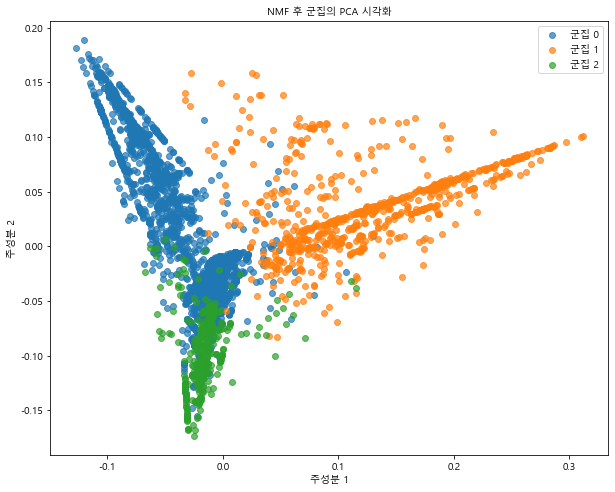

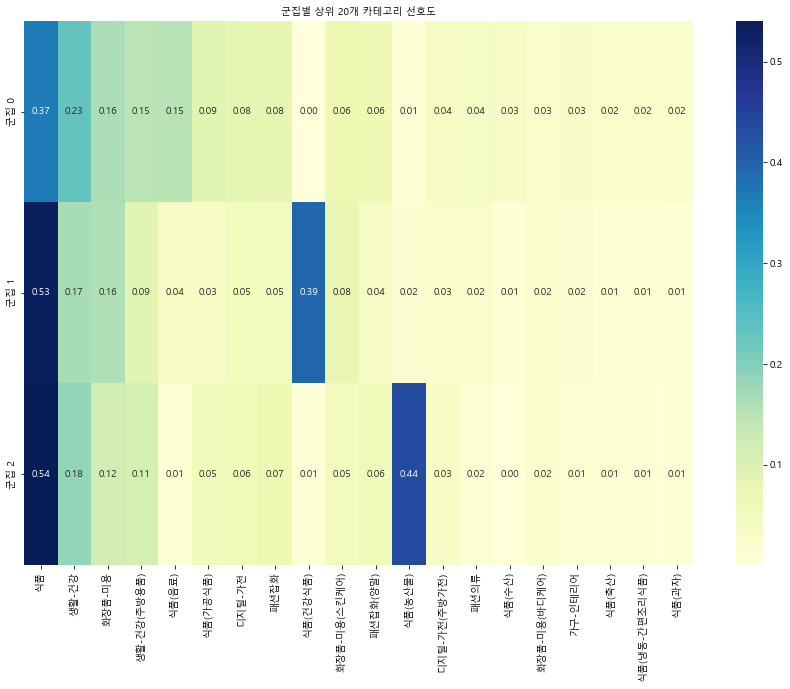

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정
# 시스템에 설치된 한글 폰트 중 하나를 선택
# Windows의 경우 일반적으로 'Malgun Gothic'(맑은 고딕)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 윈도우 기본 한글 폰트 경로
font_prop = fm.FontProperties(fname=font_path)

# matplotlib 기본 폰트 설정
plt.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 1. 주성분 분석(PCA)을 사용한 2차원 시각화
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(reduced_data)

plt.figure(figsize=(10, 8))
for cluster_id in range(n_clusters):
    mask = df_num_sp['cluster'] == cluster_id
    plt.scatter(pca_result[mask, 0], pca_result[mask, 1], label=f'군집 {cluster_id}', alpha=0.7)

plt.legend()
plt.title('NMF 후 군집의 PCA 시각화', fontproperties=font_prop)
plt.xlabel('주성분 1', fontproperties=font_prop)
plt.ylabel('주성분 2', fontproperties=font_prop)
plt.show()

# 2. 군집별 카테고리 선호도 히트맵
# 상위 20개 카테고리만 선택
top20_categories = category_data.mean().sort_values(ascending=False).head(20).index

# 각 군집의 평균 선호도
cluster_category_profiles = pd.DataFrame()
for cluster_id in range(n_clusters):
    mask = df_num_sp['cluster'] == cluster_id
    profile = category_data.loc[mask, top20_categories].mean()
    cluster_category_profiles[f'군집 {cluster_id}'] = profile

plt.figure(figsize=(15, 10))
sns.heatmap(cluster_category_profiles.T, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('군집별 상위 20개 카테고리 선호도', fontproperties=font_prop)
plt.show()

Text(0, 0.5, '빈도')

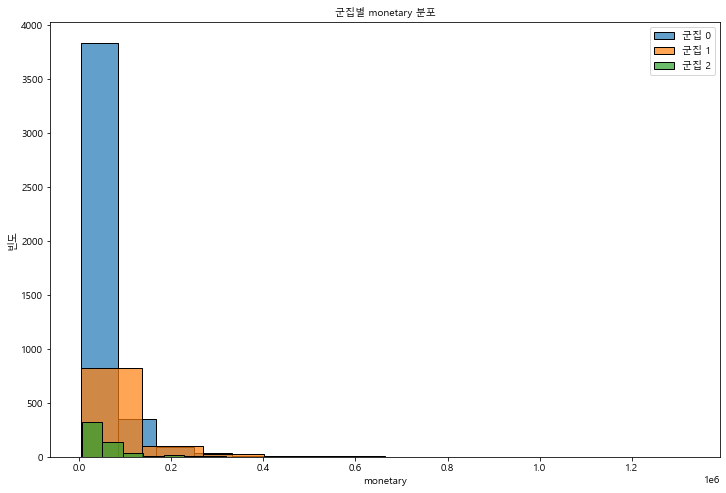

In [175]:
plt.figure(figsize=(12, 8))
for cluster_id in range(n_clusters):
    mask = df_num_sp['cluster'] == cluster_id
    sns.histplot(df_num_sp[mask].monetary, bins=10, kde=False, label=f'군집 {cluster_id}', alpha=0.7)
plt.legend()
plt.title('군집별 monetary 분포', fontproperties=font_prop)
plt.xlabel('monetary', fontproperties=font_prop)
plt.ylabel('빈도', fontproperties=font_prop)

In [188]:
df_num_sp.groupby(['cluster','grade_encoded']).agg({
    'grade_encoded':'count',
    'monetary':['mean','sum'],
    'is_churn':'sum',
    'current_shoji':'mean',
    'total_purchase_count':'mean',
    'frequency':'mean'
})


grade_encoded       monetary             is_churn  \
                              count           mean         sum      sum   
cluster grade_encoded                                                     
0       0                       381   29683.963255  11309590.0      184   
        1                       573   22396.038394  12832930.0      180   
        2                      1990   46358.743719  92253900.0      470   
        3                      1393   68104.501077  94869570.0       68   
1       0                        71   53649.014085   3809080.0       33   
        1                        44   30486.363636   1341400.0       15   
        2                       446   84023.408072  37474440.0      100   
        3                       407  100906.805897  41069070.0       17   
2       0                        30   38336.666667   1150100.0       15   
        1                        46   24370.652174   1121050.0       15   
        2                       238   48971.470588  11655210.0       58   
        3                       214   74431.869159  15928420.0        7   

                      current_shoji total_purchase_count frequency  
                               mean                 mean      mean  
cluster grade_encoded                                               
0       0               2796.661417             2.456693  1.005249  
        1               3291.638743             2.165794  1.638743  
        2               3478.276884             2.980402  2.389950  
        3               3897.008615             4.132089  3.404164  
1       0               1965.507042             3.225352  1.000000  
        1               2199.318182             2.272727  1.409091  
        2               3898.313901             4.139013  2.834081  
        3               3315.761671             5.503686  4.169533  
2       0               2684.433333             2.666667  1.000000  
        1               3419.369565             2.130435  1.630435  
        2               3817.865546             3.092437  2.462185  
        3               3793.864486             4.228972  3.574766

### Cat-1 기반 군집화